In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np


# Info datos crudo

In [ ]:

# Ruta al directorio donde están las imágenes DICOM
dicom_dir = "dataset/gatos/Normal"
dicom_dirs = [dicom_dir, "dataset/gatos/Artrosis/Ligera/", "dataset/gatos/Artrosis/Leve/", 
              "dataset/gatos/Artrosis/Moderada/", "dataset/gatos/Artrosis/Severa/"]

def load_dicom_images(directories, num = None):
    """Carga todas las imágenes DICOM de un directorio."""
    dicom_files_c = []
    classes = ['0', '1', '2', '3', '4']
    for directory, c in zip(directories,classes):
        dicom_files_c.append([(os.path.join(directory, f), c) for f in os.listdir(directory) if f.endswith('.dcm')])
    dicom_images = []
    for class_number, dicom_files_class in enumerate(dicom_files_c):
        dicom_files = [f for f, c in dicom_files_class]
        c = dicom_files_class[0][1]
        print(f"Clase {class_number}: {dicom_files[0]}")
        for i, file in enumerate(dicom_files):
            if num is not None and i >= num:
                break
            try:
                ds = pydicom.dcmread(file)
                dicom_images.append((ds, c))
            except Exception as e:
                print(f"Error al cargar {file}: {e}")
    return dicom_images

def display_dicom_image(dicom_image):
    """Muestra una imagen DICOM usando matplotlib."""
    plt.imshow(dicom_image.pixel_array, cmap=plt.cm.gray)
    plt.title(f"Paciente: {dicom_image.PatientID}")
    plt.axis('off')
    plt.show()
def print_dicom_metadata(dicom_image):
    """Imprime los metadatos más relevantes de una imagen DICOM."""
    print("Información del archivo DICOM:")
    print(f"Patient ID: {dicom_image.get('PatientID', 'Desconocido')}")
    print(f"View position: {dicom_image.get('ViewPosition', 'Desconocido')}")
    print(f"Protocol Name: {dicom_image.get('ProtocolName', 'Desconocido')}")

    print("-" * 40)
# Cargar las imágenes
dicom_images = load_dicom_images(dicom_dirs)

# Visualizar las primeras imágenes
cat = {}
for i, (dicom_image, class_number) in enumerate(dicom_images):  # Cambia el rango según lo necesites
    cat_id = dicom_image.PatientName
    if cat_id not in cat:
        cat[cat_id] = {
            "class_number": []
        }
    cat[cat_id]["class_number"].append(class_number)
    
print(cat)
    

In [ ]:
images_class = [0, 0, 0, 0, 0]
for c in cat:
    for i in cat[c]["class_number"]:
        images_class[int(i)] += 1
print(images_class)
print(sum(images_class))

# Guardar como png

In [ ]:
mri_folders = ["dataset/gatos/Normal", "dataset/gatos/Artrosis/Ligera/", "dataset/gatos/Artrosis/Leve/",
                "dataset/gatos/Artrosis/Moderada/", "dataset/gatos/Artrosis/Severa/"]
png_folders = ["dataset/gatos/png/0", "dataset/gatos/png/1/", "dataset/gatos/png/2/",
                "dataset/gatos/png/3/", "dataset/gatos/png/4/"]
import cv2
# Asegurarse de que las carpetas de salida existen
for png_folder in png_folders:
    os.makedirs(png_folder, exist_ok=True)

for mri_folder, png_folder in zip(mri_folders, png_folders):
    for f in os.listdir(mri_folder):
        if f.endswith('.dcm'):
            dicom_path = os.path.join(mri_folder, f)
            try:
                # Leer el archivo DICOM
                dicom = pydicom.dcmread(dicom_path)
                img = dicom.pixel_array
                img = np.array(img, dtype = float) 
                img = (img - img.min()) / (img.max() - img.min()) * 255.0  
                img = img.astype(np.uint8)
                # Guardar como PNG
                output_path = os.path.join(png_folder, f.replace('.dcm', '.png'))
                #cv2.imwrite(output_path, img)
                print(f"Guardado: {output_path}")
            except Exception as e:
                print(f"Error al procesar {dicom_path}: {e}")

# DATOS RODILLA 

In [ ]:
data_dir = 'dataset/gatos/png/'
# Obtener la lista de subdirectorios (clases)
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

matrix = []
for subdir in subdirs:
    # Obtener la lista de archivos en el subdirectorio
    files = os.listdir(os.path.join(data_dir, subdir))
    
    # Imprimir la clase y la cantidad de imágenes

    matrix.append(len(files))

# Crear un gráfico de barras
plt.bar(subdirs, matrix)
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes por clase')
plt.tight_layout()
plt.show()

print(f"Total de imágenes: {sum(matrix)}")


In [ ]:
num_per_class = {
}

for gato in cat:
    for artrosis in cat[gato]['class_number']:
        if artrosis not in num_per_class:
            num_per_class[artrosis] = 0
        num_per_class[artrosis] += 1


In [ ]:
num_per_class

# Grad-Cam

In [ ]:
from torch import nn
from torchvision.models import *

# Clase EfficientNetB5Custom
class EfficientNetB5Custom(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super(EfficientNetB5Custom, self).__init__()
        if pretrained:
            self.efficientnet = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        else:
            self.efficientnet = efficientnet_b5(weights=None)
        self.name = "EfficientNetB5Custom"
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.efficientnet(x)


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from src.grad_cam import GradCAM
model_state = torch.load(r'models\OAI Mendeley\best_model_EfficientNetB5Custom_epoch_2.pt',map_location=torch.device('cpu'), weights_only=False)
model = EfficientNetB5Custom(num_classes=5, pretrained=False)
model.load_state_dict(model_state)
#model = torch.load(r'models\OAI Mendeley\best_model_EfficientNetB5_epoch_30.pt',map_location=torch.device('cpu'), weights_only=False)
model = torch.load(r'models\OAI Mendeley\EfficientNetB0.pt',map_location=torch.device('cpu'), weights_only=False)
model.eval()
target_layer = model.efficientnet.features[-1]

grad_cam = GradCAM(model, target_layer)

In [75]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from src.config import *
from src.data import HistogramEqualization, BilateralFilter
# Diccionario de clases (ajústalo según tu dataset)
idx_to_class = {0: "Sano", 1: "Dudoso", 2: "Leve", 3: "Grave", 4: "Muy Grave"}

matrix_confusion = np.zeros((5, 5), dtype=int)  # Inicializar matriz de confusión
# Cargar el modelo
# Obtener rutas de imágenes y clases reales
dataset_path = "dataset/gatos/clean/"
#dataset_path = "dataset/experimento1/split_oai/test"
img_paths = []
for class_idx, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    i = 0
    for image_name in os.listdir(class_path):
        i += 1
        image_path = os.path.join(class_path, image_name)
        img_paths.append((image_path, class_idx))
        if i > 1:
            break
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Fixed missing comma
    transforms.ToTensor(),
     # Standard ImageNet normalization
])


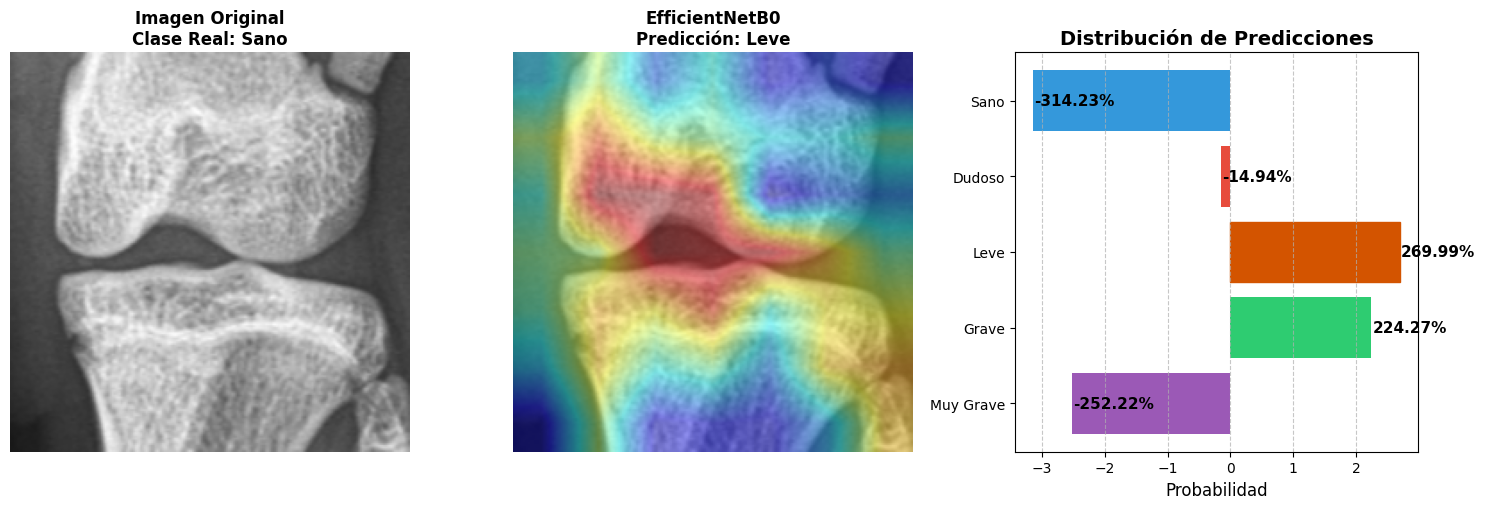

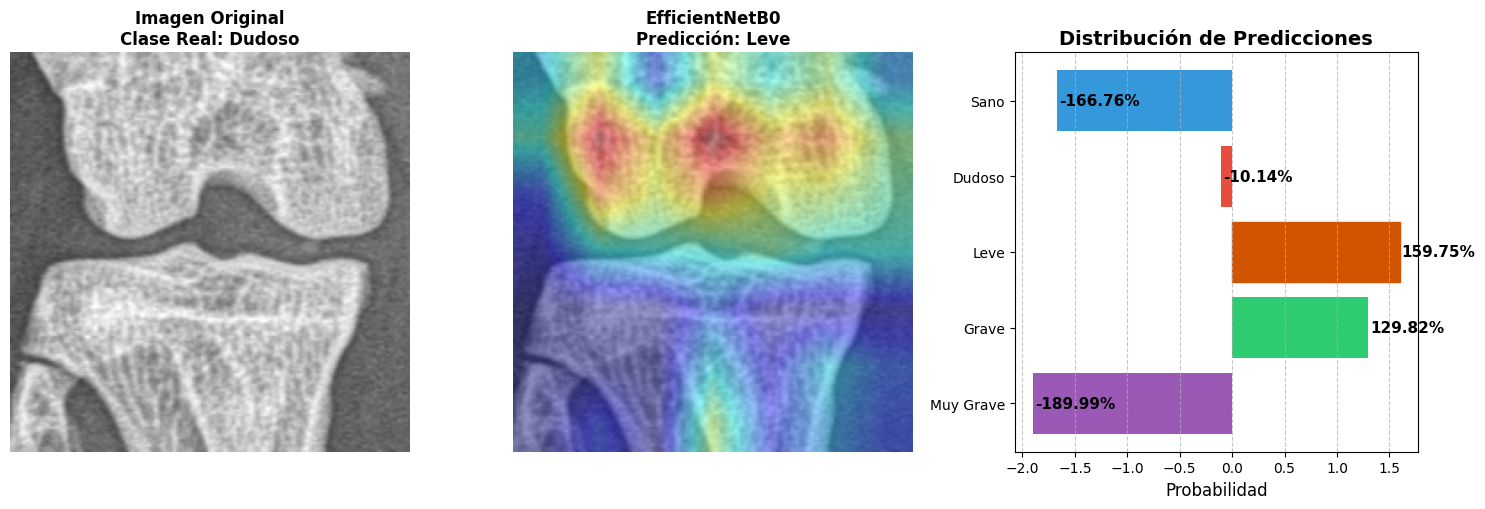

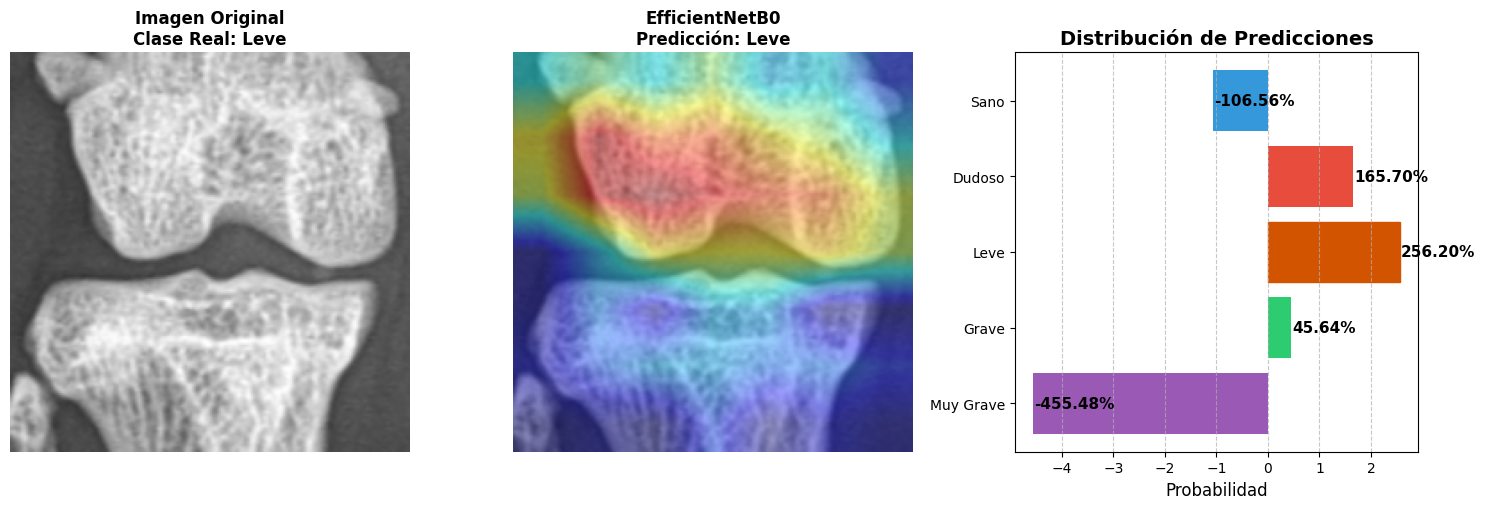

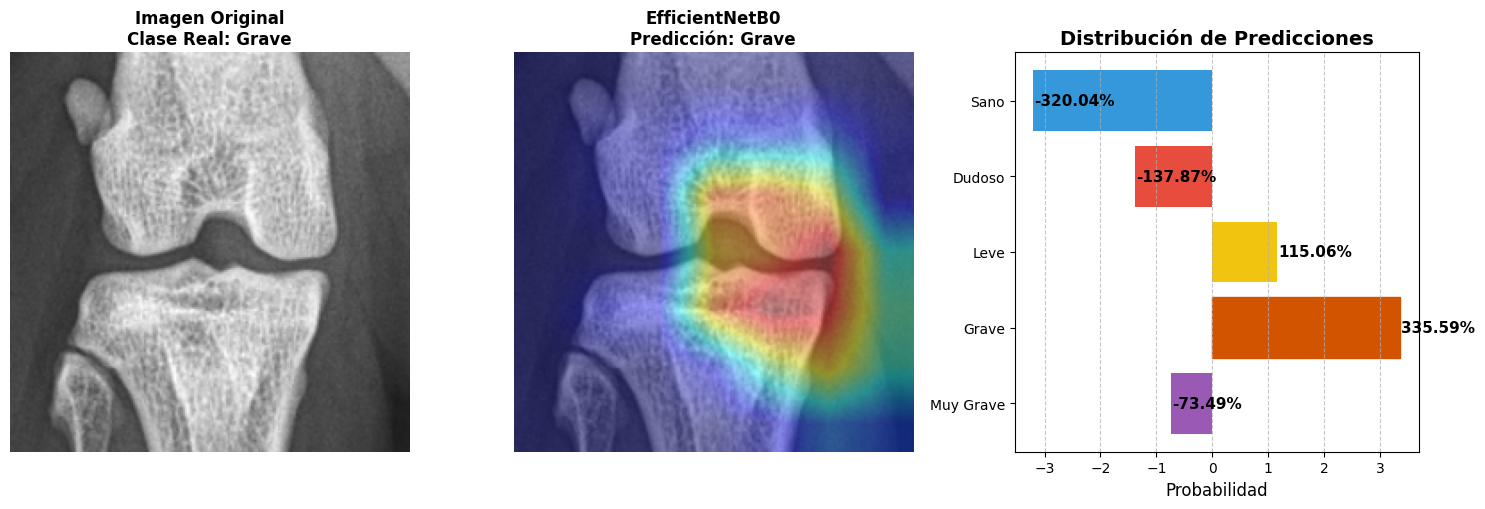

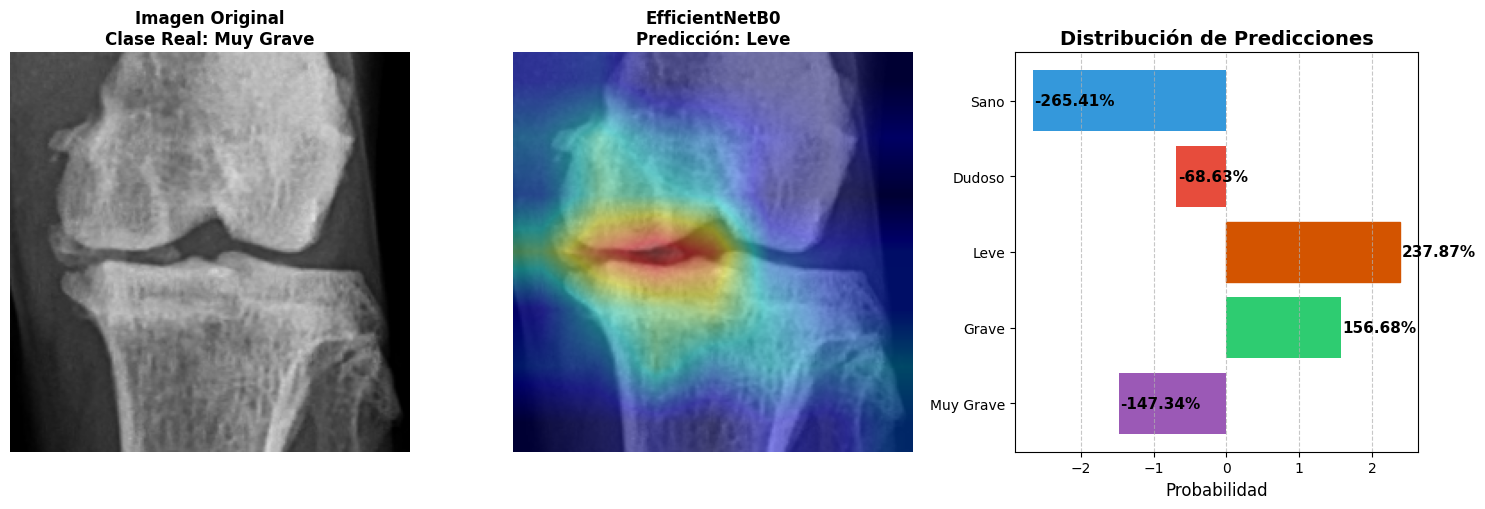

[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]


In [76]:
# Procesar y predecir cada imagen
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        output = output.squeeze(0)  # Eliminar batch dimension
        probabilities = output  # Aplanar las salidas

        predicted_idx = probabilities.argmax().item()  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase
        matrix_confusion[real_class][predicted_idx] += 1  # Actualizar matriz de confusión
    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")

    # **Gráfica de distribución de predicciones con diseño mejorado**
    class_names = list(idx_to_class.values())
    bars = ax[2].barh(class_names, probabilities.numpy(), color=["#3498db", "#e74c3c", "#f1c40f", "#2ecc71", "#9b59b6"])
    
    # Resaltar la clase con mayor probabilidad
    max_index = predicted_idx
    bars[max_index].set_color("#d35400")

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()
print(matrix_confusion)


0.0033381283283233643 Sano


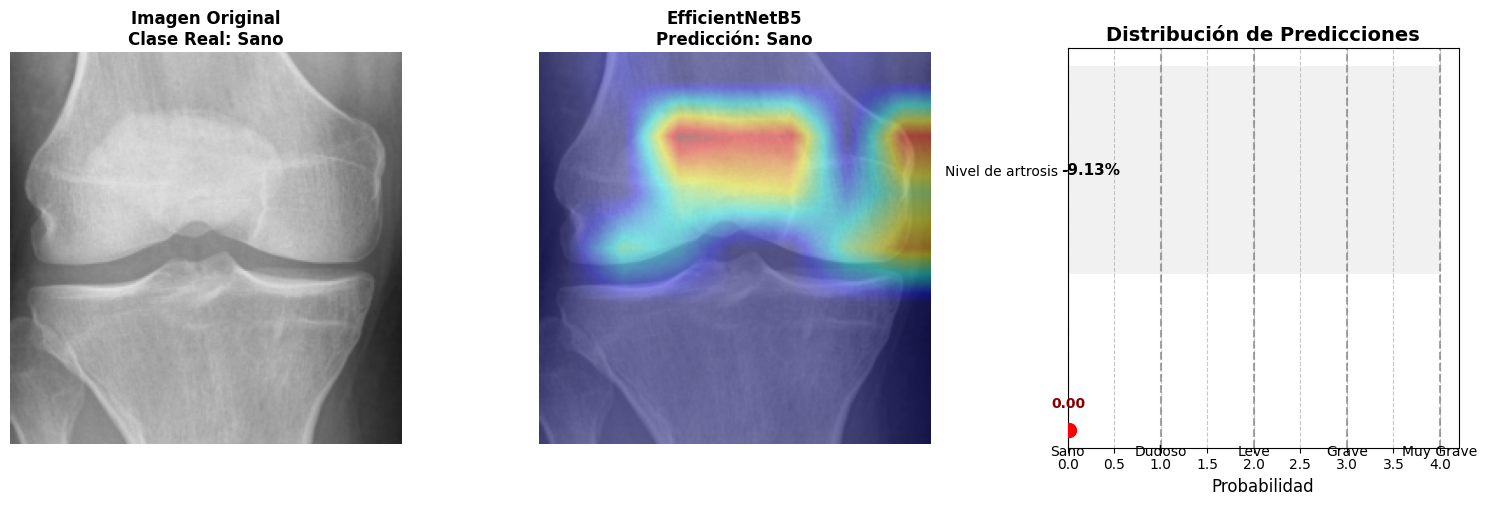

-0.00014925748109817505 Sano


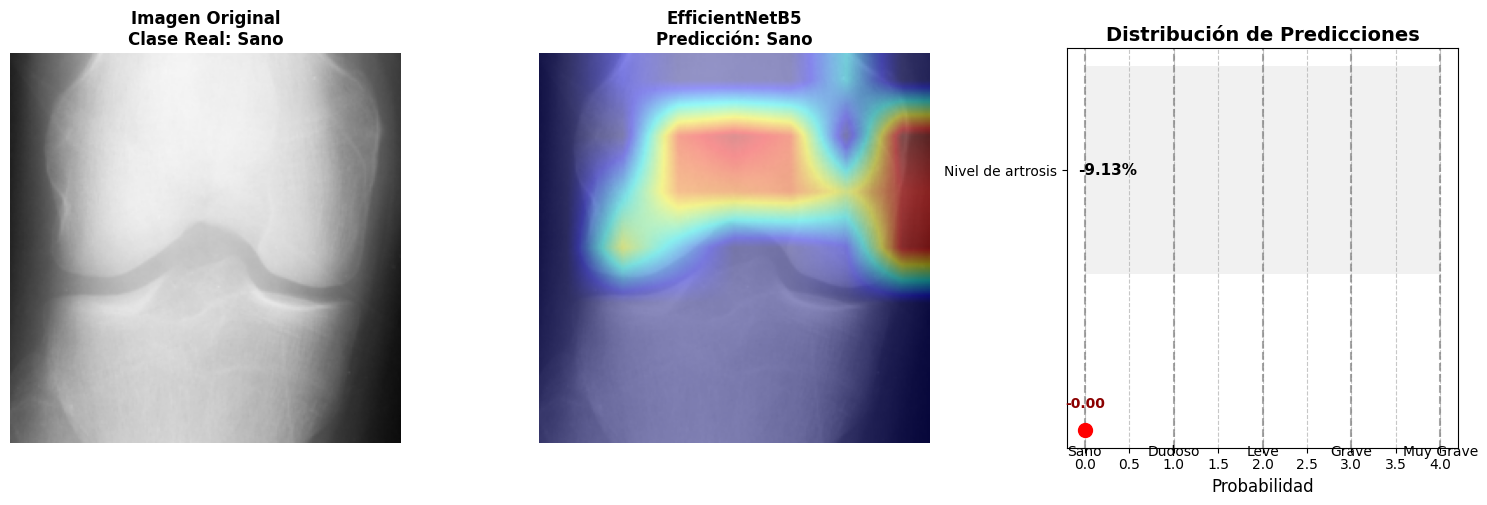

0.0011174678802490234 Sano


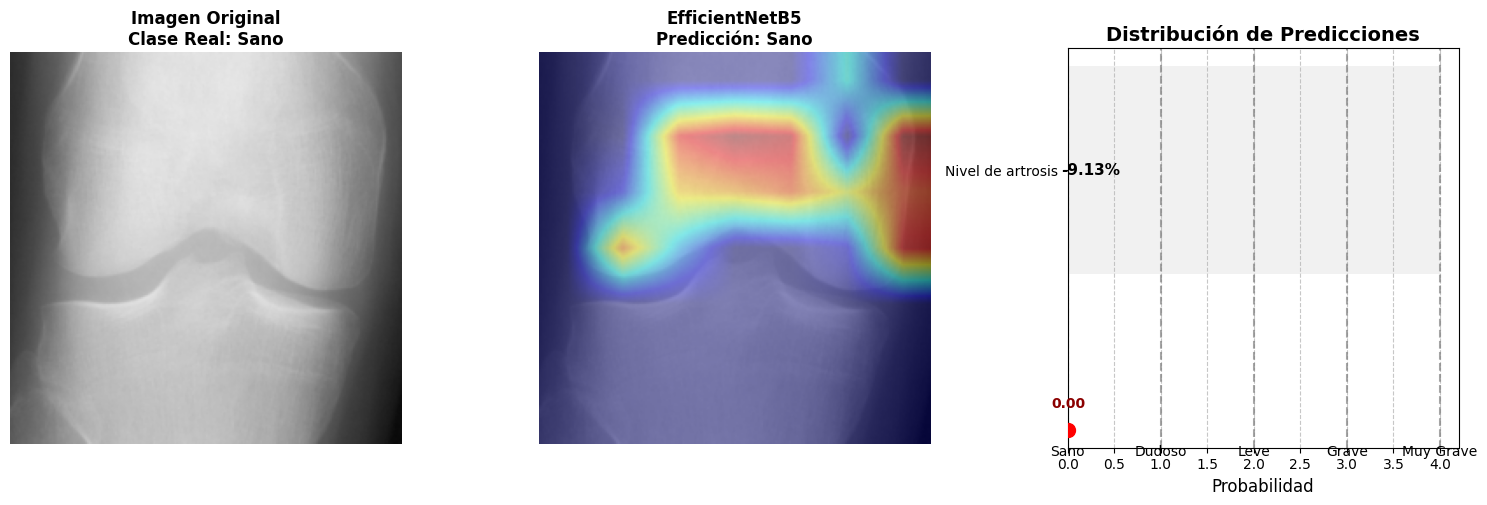

0.0007073879241943359 Sano


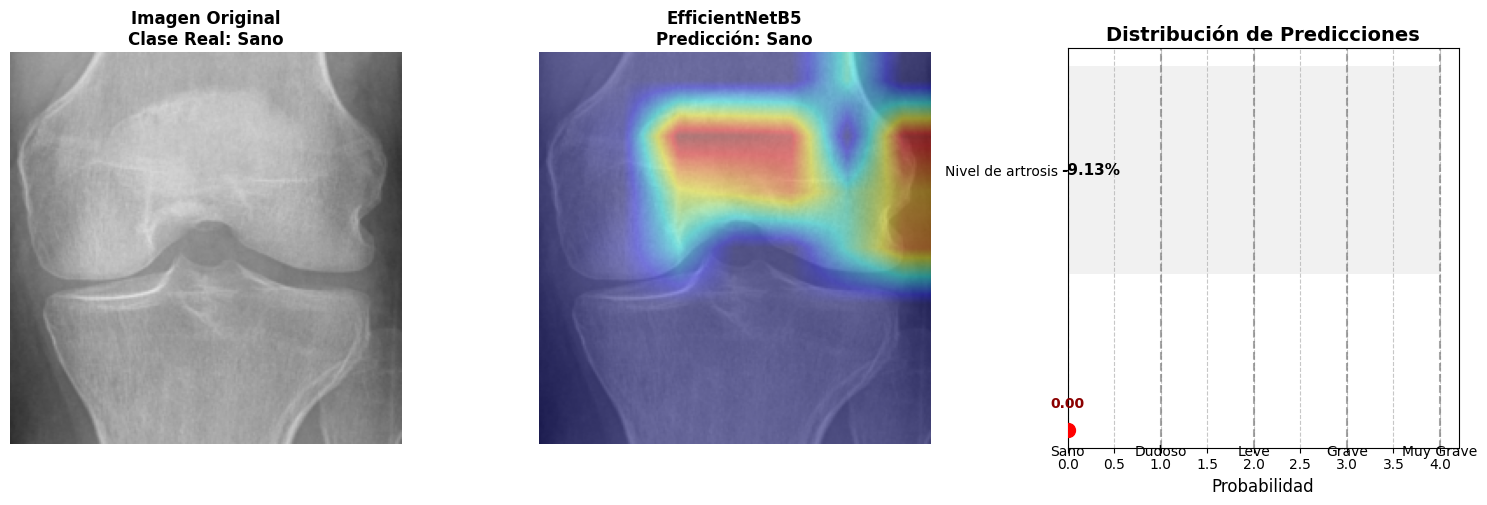

-0.005307577550411224 Sano


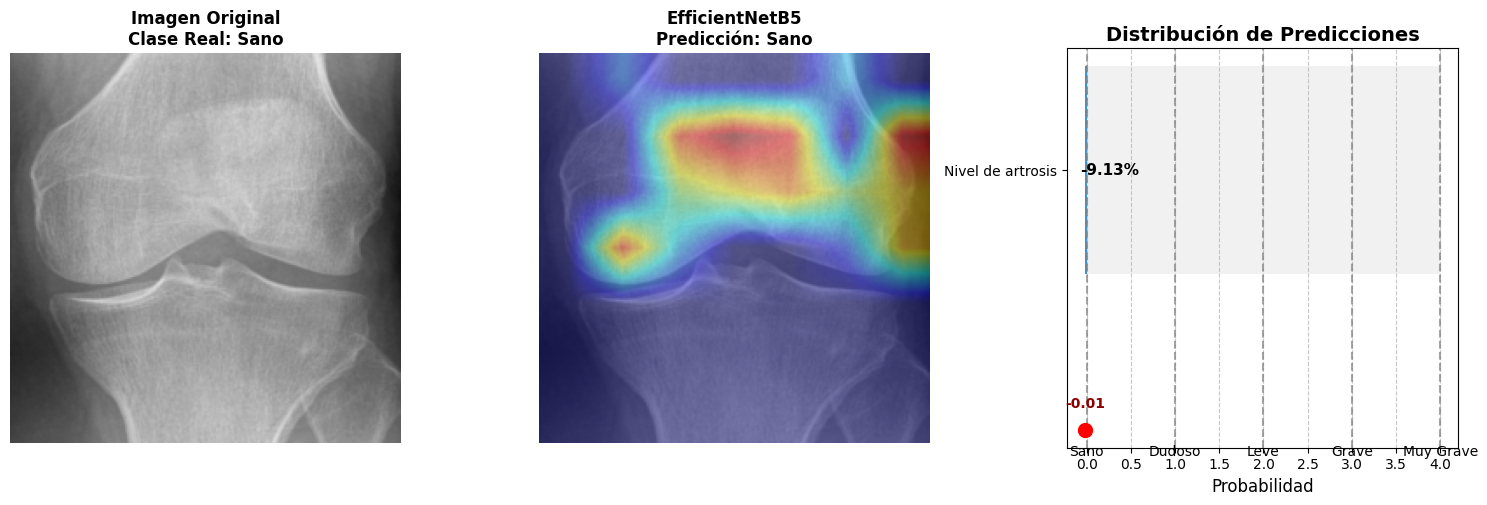

0.25455936789512634 Dudoso


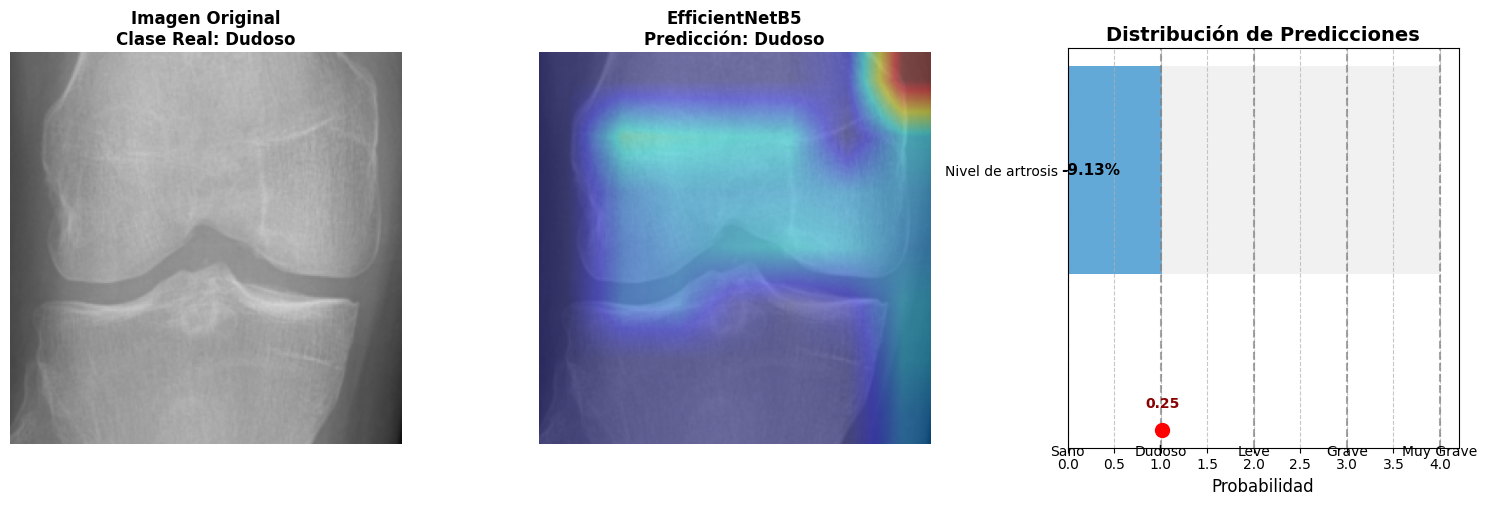

0.2428518682718277 Dudoso


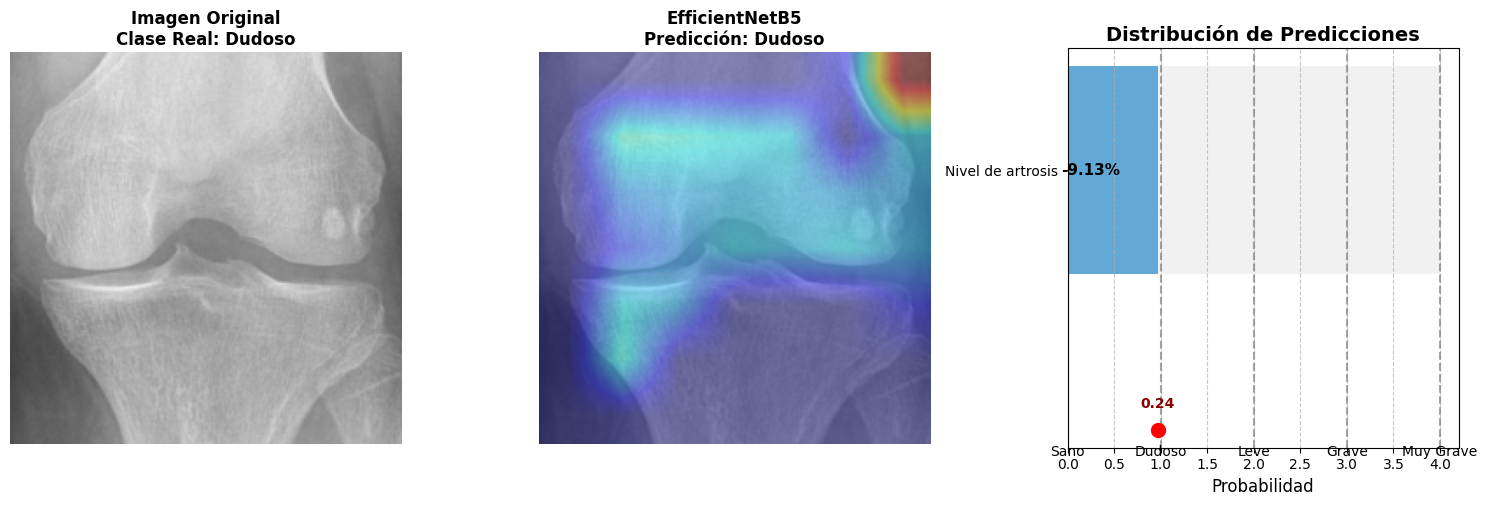

0.050600744783878326 Sano


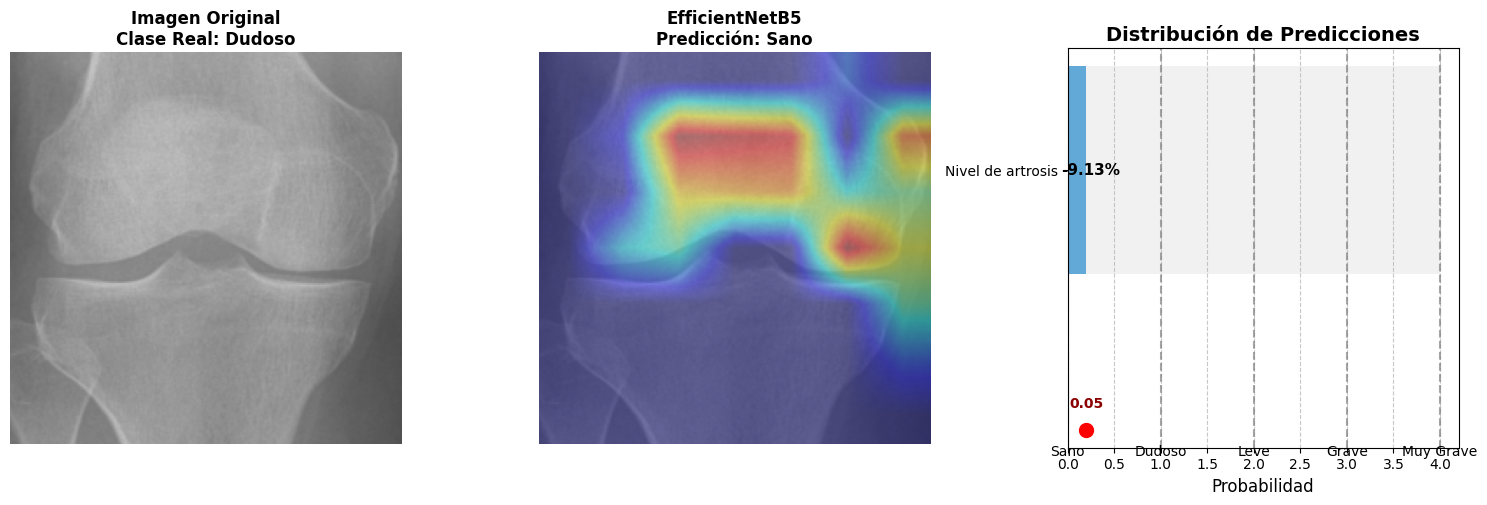

0.34987664222717285 Dudoso


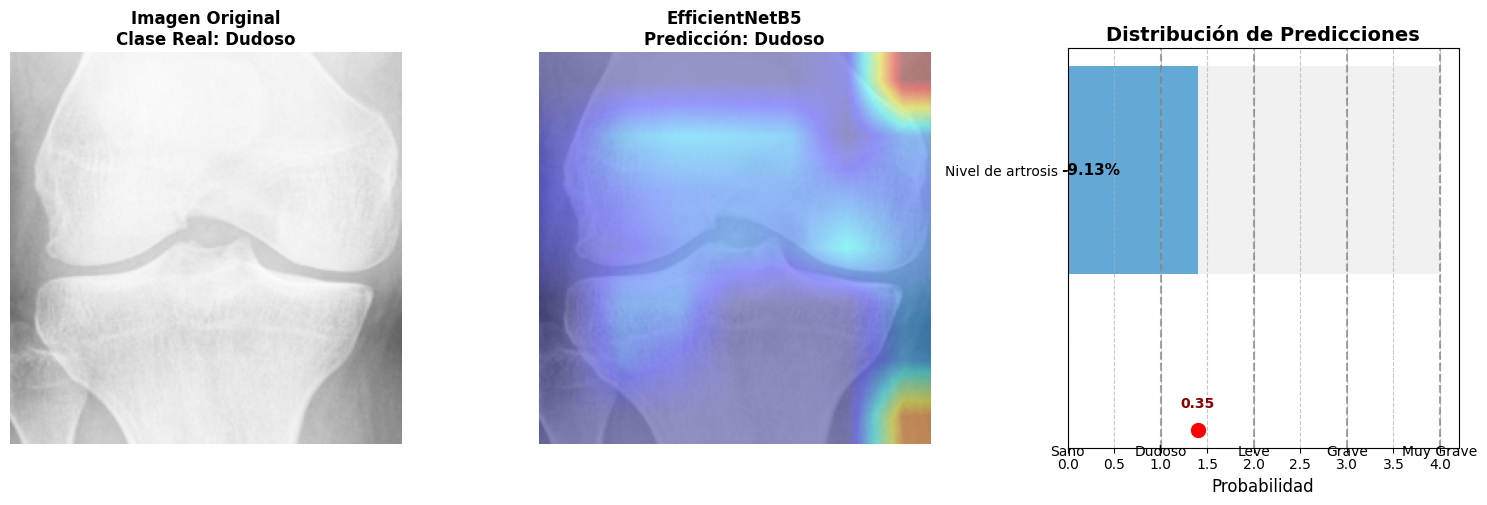

0.2508624196052551 Dudoso


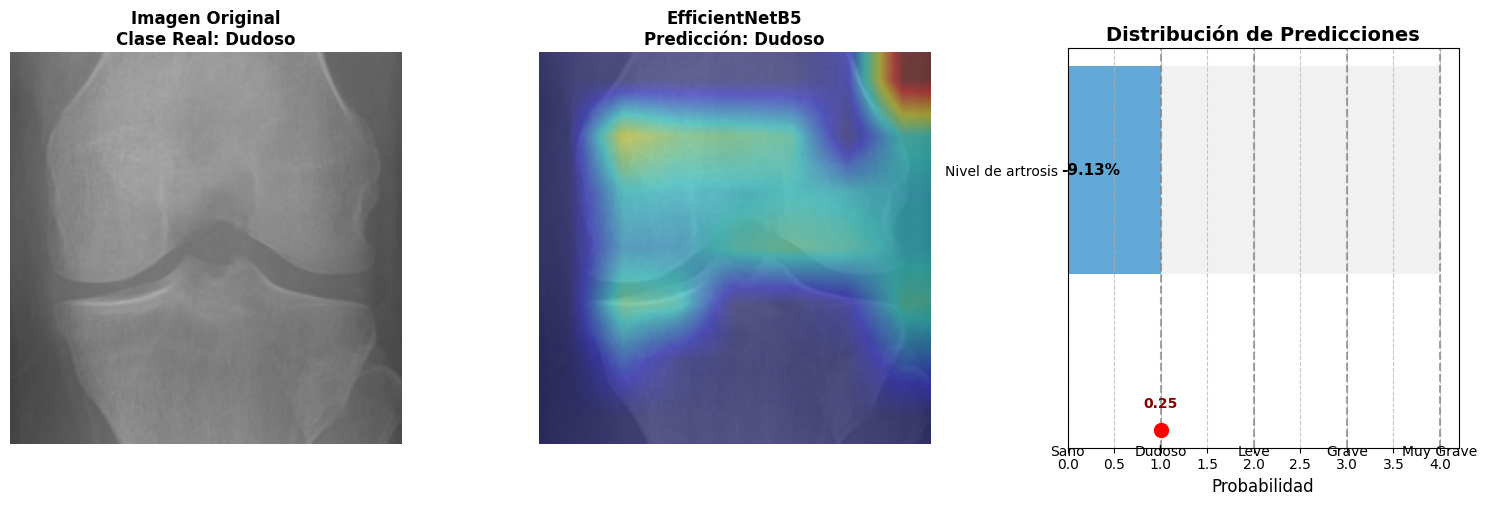

0.5123400092124939 Leve


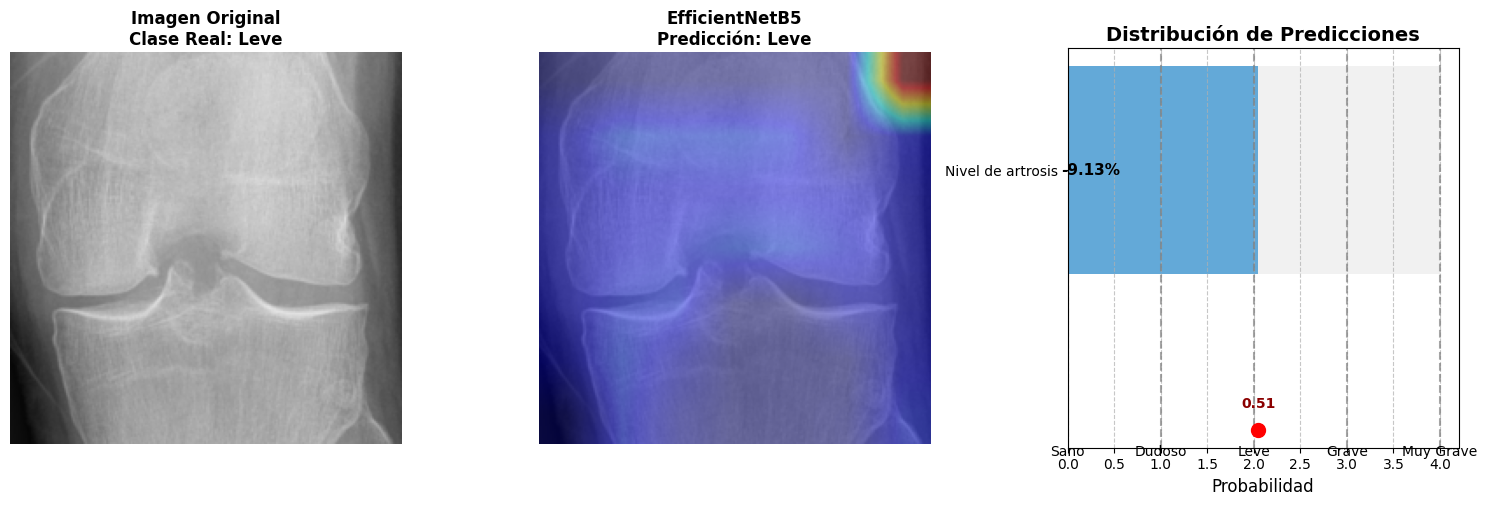

0.2588893473148346 Dudoso


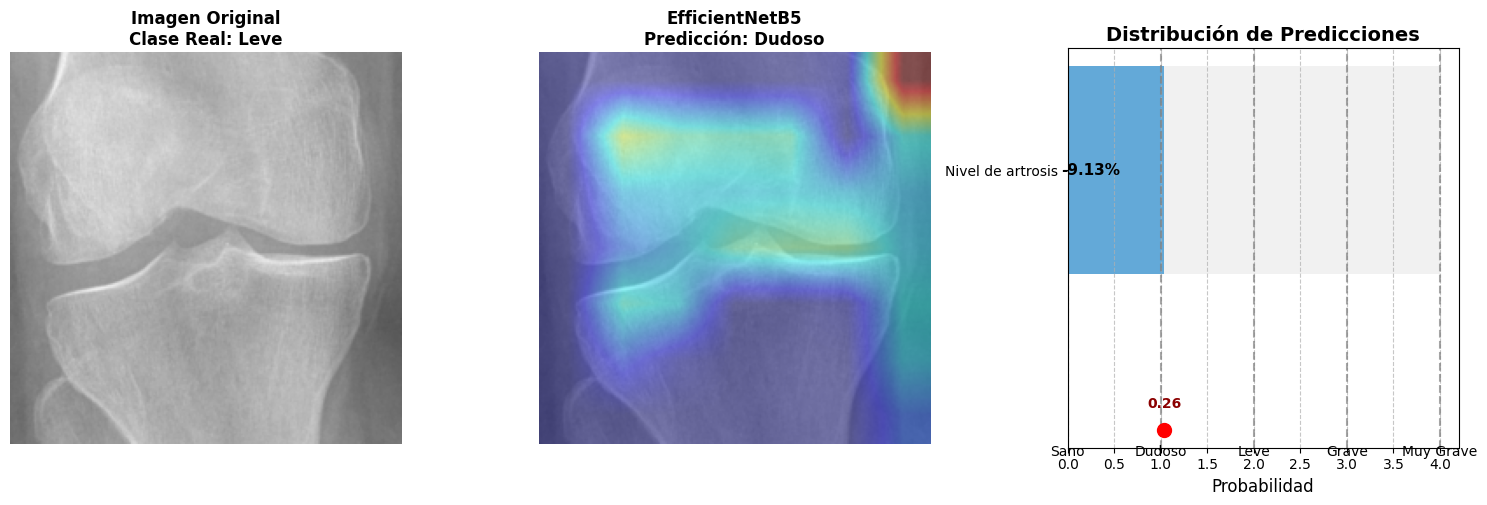

0.5118873119354248 Leve


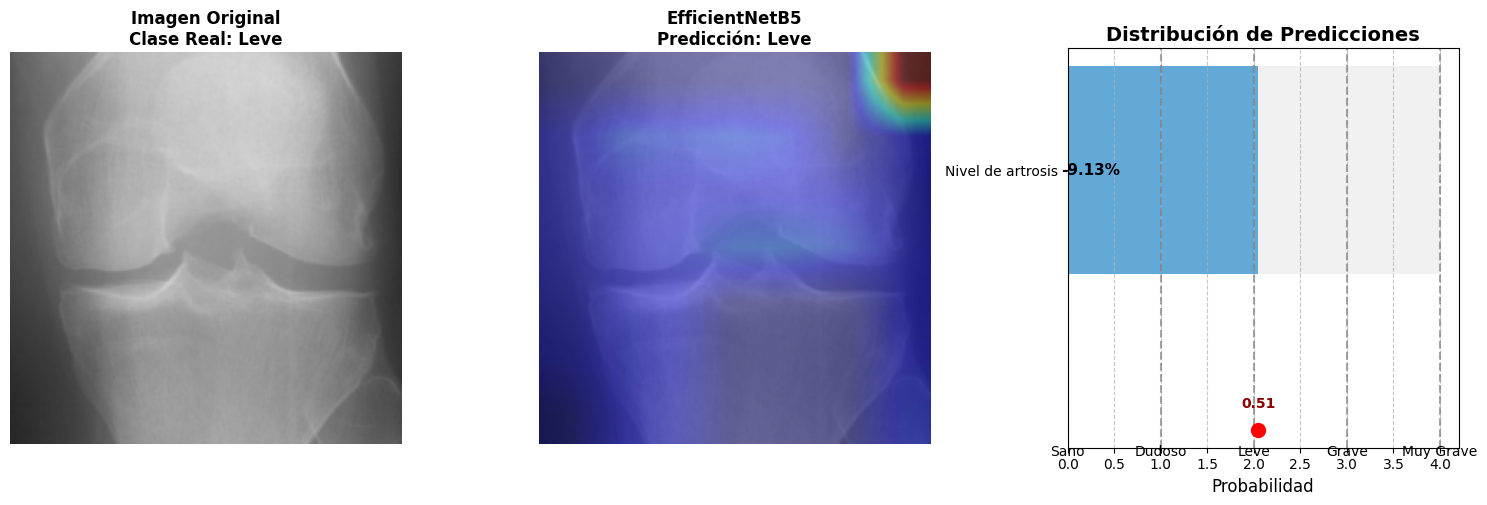

0.5538477301597595 Leve


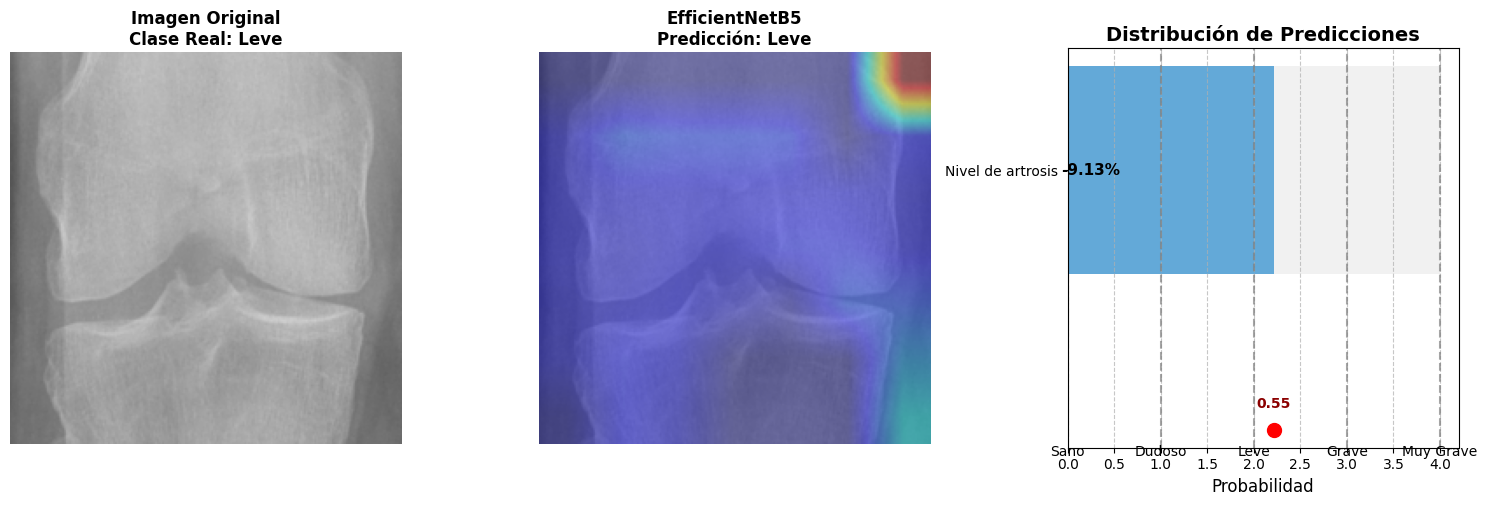

0.265762597322464 Dudoso


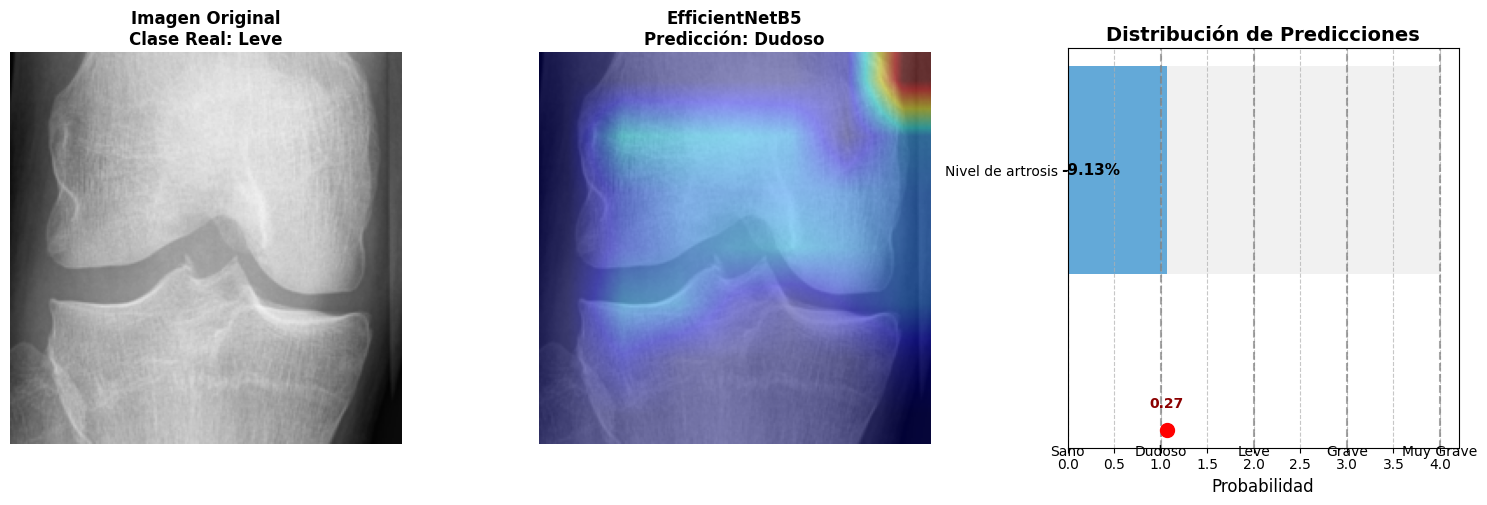

0.2867390513420105 Dudoso


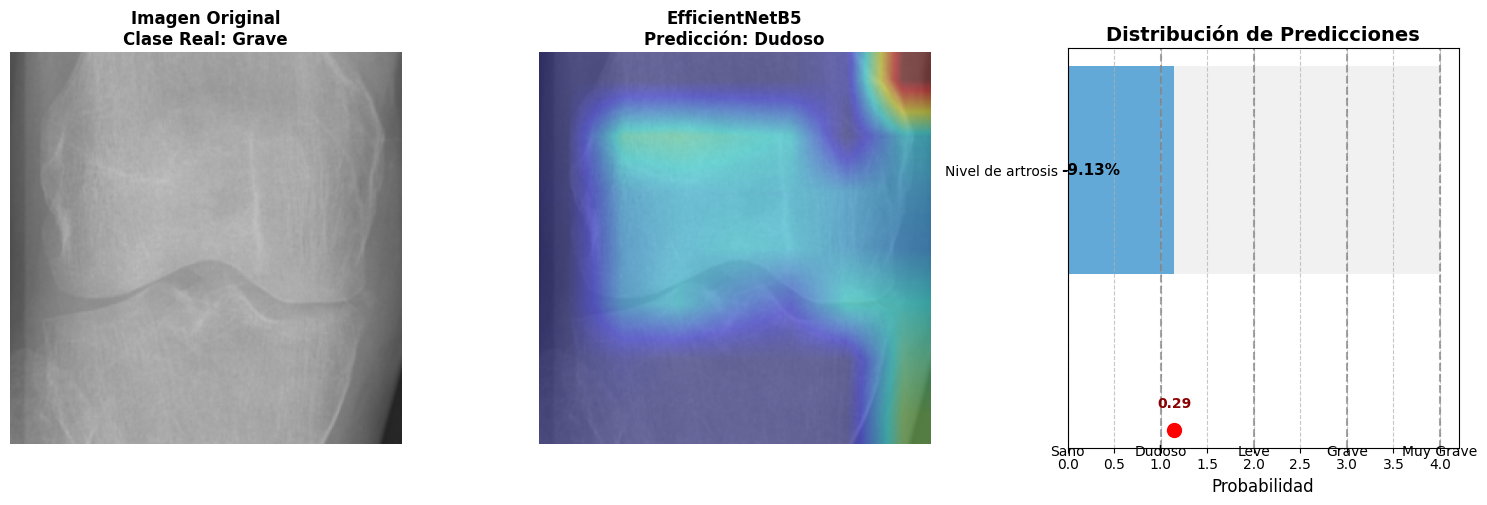

0.6970680952072144 Grave


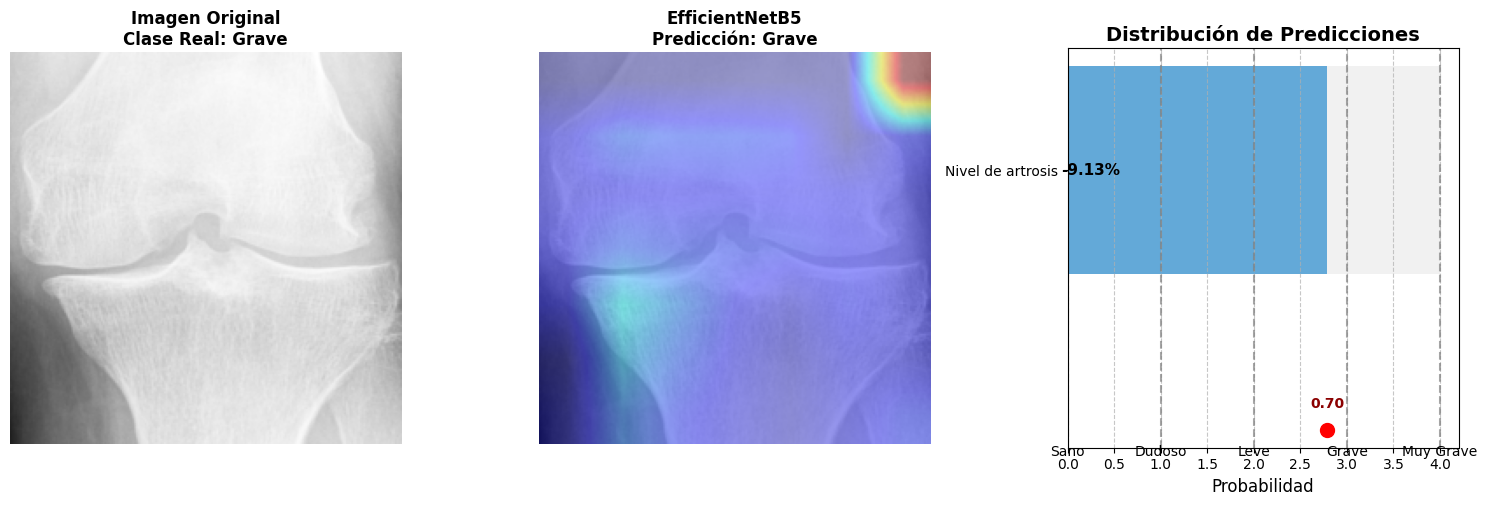

0.6342666745185852 Grave


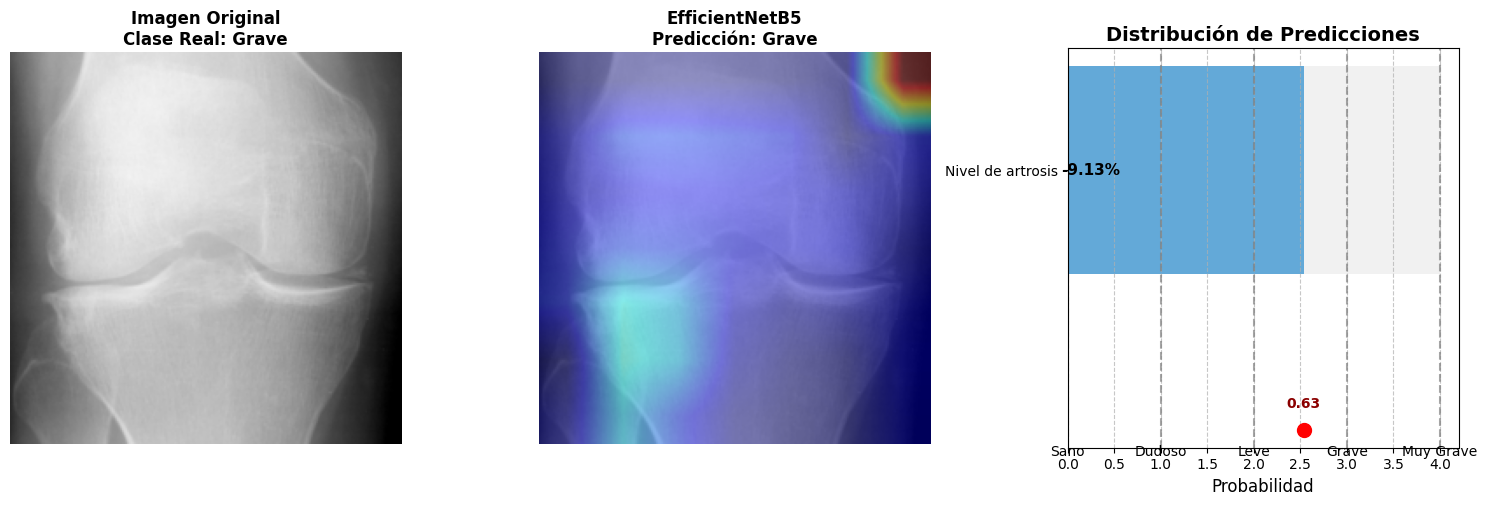

0.7524641156196594 Grave


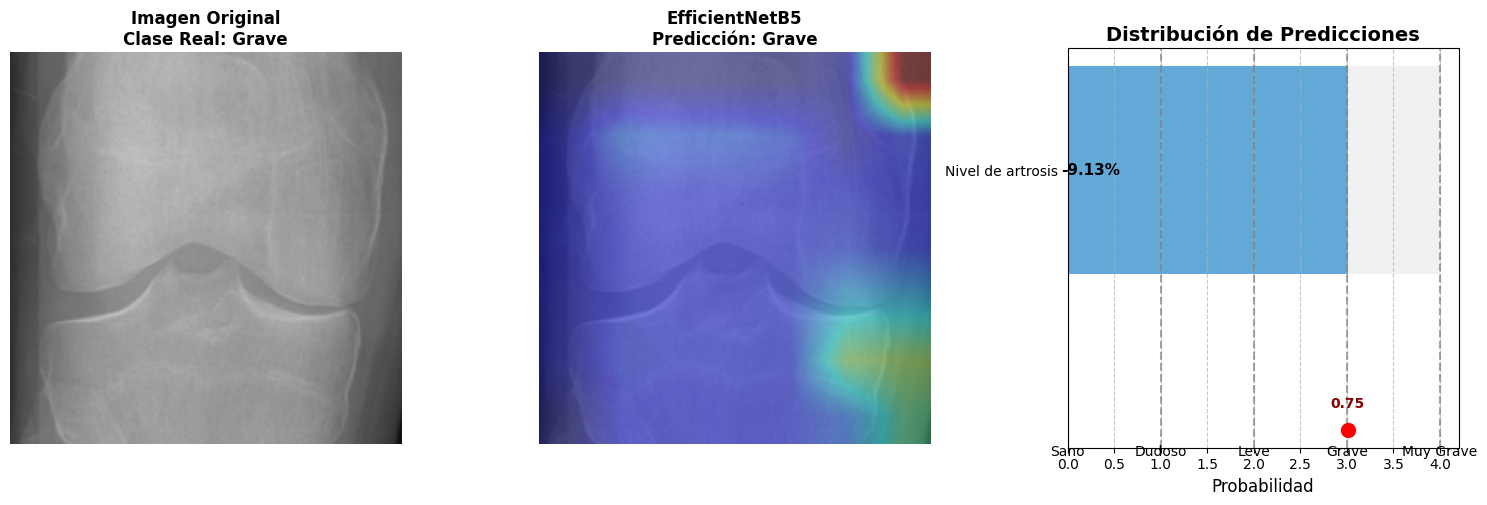

0.7075512409210205 Grave


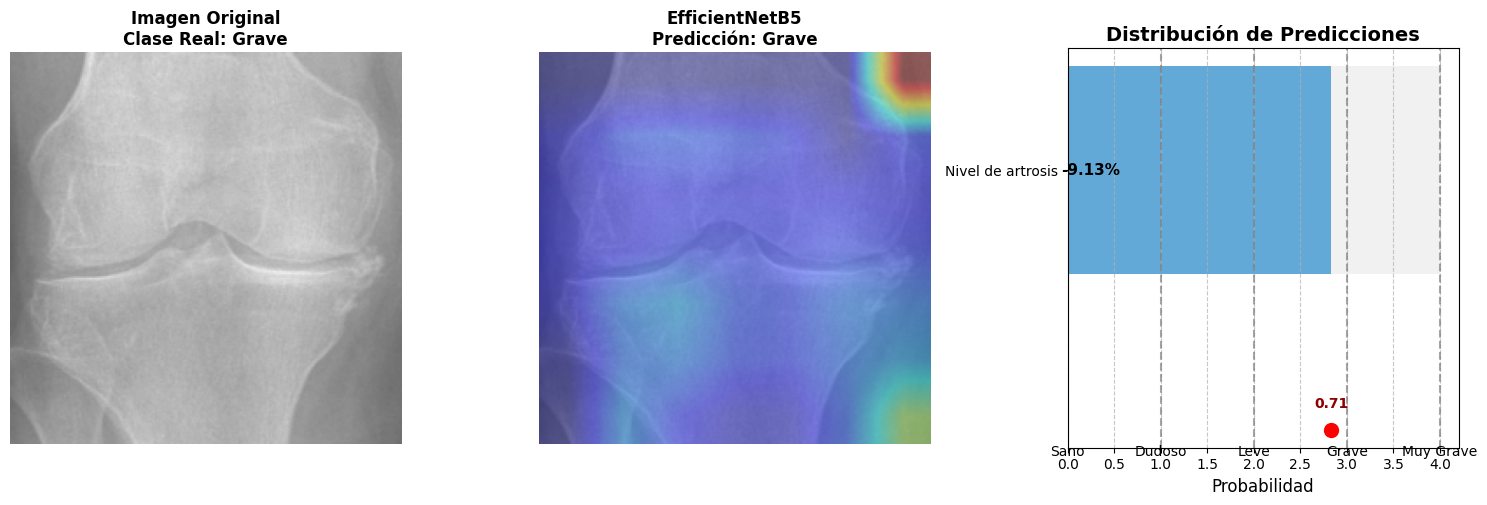

0.9693167209625244 Muy Grave


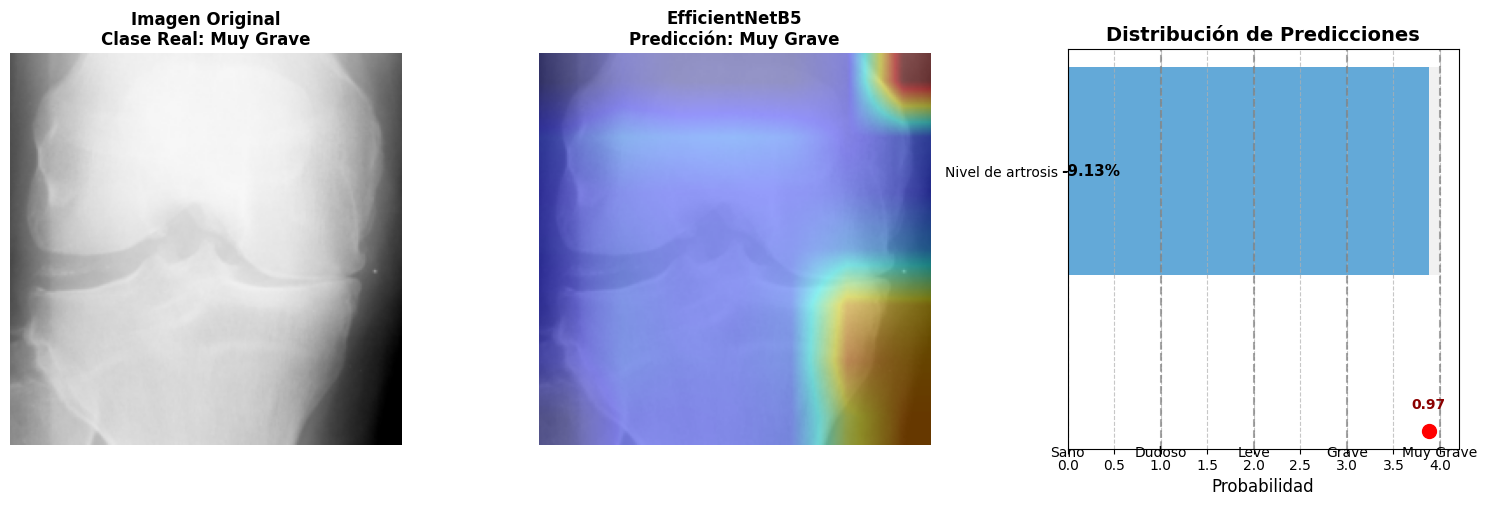

0.7565995454788208 Grave


KeyboardInterrupt: 

In [39]:
# REGRESION

def get_prediction(output):
    """Devuelve la predicción de la clase a partir de la salida de regresion del modelo"""
    # Output is a number between 0 and 1
    # Convert to class index (0-4)
    if output < 0.2:
        return 0
    elif output < 0.4:
        return 1
    elif output < 0.6:
        return 2
    elif output < 0.8:
        return 3
    else:
        return 4 
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        output = output.squeeze(0)  # Eliminar batch dimension
        probabilities = output  # Aplanar las salidas

        predicted_idx = get_prediction(output.item())  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase
        matrix_confusion[real_class][predicted_idx] += 1  # Actualizar matriz de confusión
        print(output.item(), predicted_class)
    
    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")
    # **Gráfica para visualizar la predicción en formato de regresión**
    ax[2].barh(['Nivel de artrosis'], output.item()*4, color='#3498db')
    
    # Crear una barra de fondo que represente el rango completo (0-4)
    ax[2].barh(['Nivel de artrosis'], 4, color='lightgray', alpha=0.3)
    
    # Añadir marcadores para cada clase
    for i in range(5):
        ax[2].axvline(x=i, color='gray', linestyle='--', alpha=0.7)
        ax[2].text(i, 1.1, idx_to_class[i], ha='center', fontsize=10)
    
    # Resaltar la predicción actual
    ax[2].scatter(output.item()*4, 1, color='red', s=100, zorder=5)
    ax[2].text(output.item()*4, 0.9, f"{output.item():.2f}", ha='center', 
               va='center', fontweight='bold', color='darkred')

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()

